# Galaxy vs Quasar

### WIP - Unfinished!!

In [76]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve, roc_curve)
from sklearn.neighbors import KernelDensity

import corner
from astropy.io import ascii
from tqdm import tqdm


plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 12

In [2]:
data = ascii.read('../solutions/galaxyquasar.csv', header_start=0)

In [3]:
data

u,g,r,i,z,class,z1,zerr
float64,float64,float64,float64,float64,str6,float64,float64
18.97213,18.53676,18.5828,18.34936,18.29215,QSO,0.5228189,0.0001547483
19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.1228459,2.816076e-05
19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.0,0.0
19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.1474355,9.310701e-06
19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.0006307968
17.60994,15.90911,15.0209,14.54955,14.19971,GALAXY,0.04619161,1.022329e-05
18.50014,17.42286,17.03657,16.76236,16.63258,GALAXY,0.0516851,6.667251e-06
19.53253,19.49823,19.42254,19.07912,18.90426,QSO,1.88844,0.0005242734
19.37014,17.94086,17.154,16.74367,16.42825,GALAXY,0.137445,1.284492e-05


In [4]:
u_g = (data['u'] - data['g'])[:, None]
g_r = (data['g'] - data['r'])[:, None]
r_i = (data['r'] - data['i'])[:, None]
i_z = (data['i'] - data['z'])[:, None]

### Quasar == 1

### Galaxy == 0

In [24]:
label = np.where(data['class'] == 'QSO', 1, 0)
label

array([1, 0, 0, ..., 0, 0, 0])

In [6]:
label

array([1, 0, 0, ..., 0, 0, 0])

In [7]:
label.shape

(50000,)

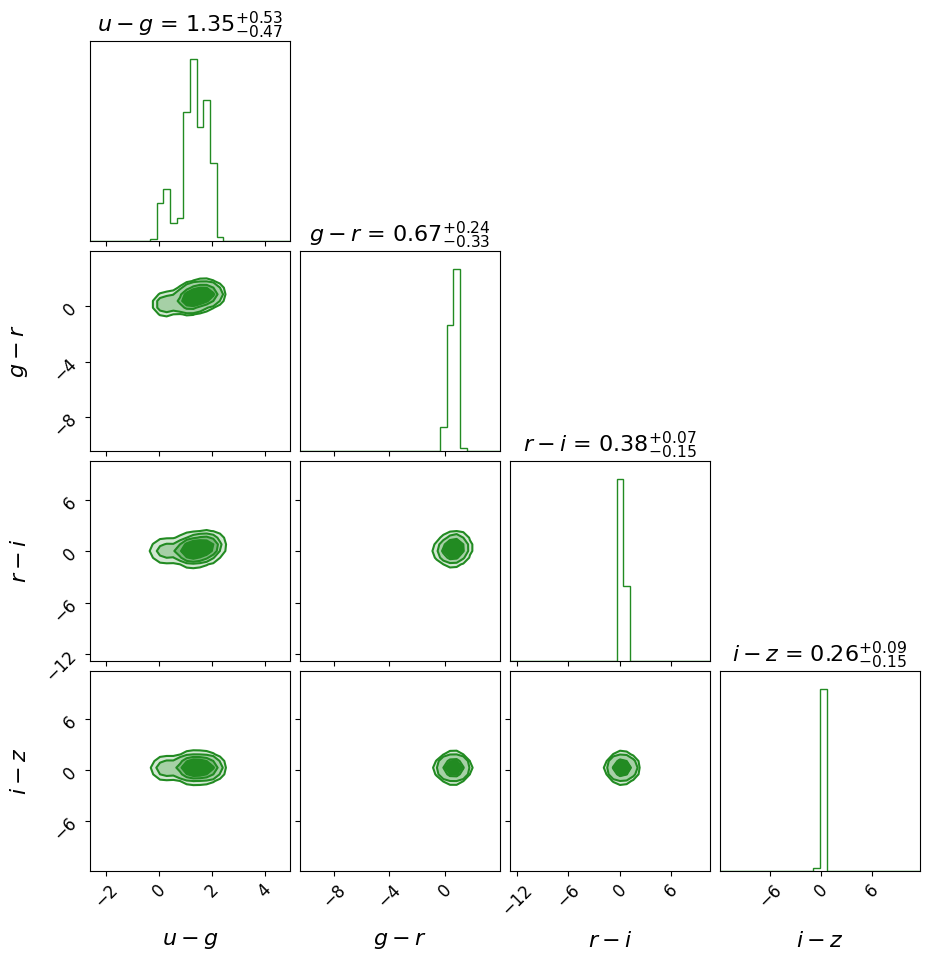

In [54]:
tofit = np.column_stack([u_g, g_r, r_i, i_z])
labels = [r"$u-g$", r"$g-r$", r"$r-i$", r"$i-z$"]

#Pretty-plotting arguments for corner plots
CORNER_KWARGS = dict(
    smooth = 1,
    label_kwargs = dict(fontsize=16),
    title_kwargs = dict(fontsize=16),
    bins = 30,
    labels = labels,
    #quantiles = [0.05, 0.50, 0.95],
    levels = [0.50, 0.68, 0.85, 0.95],
    color = 'forestgreen',
    plot_density = False,
    plot_datapoints = False,
    fill_contours = True,
    show_titles = True,
    max_n_ticks = 4
)

corner.corner(tofit, **CORNER_KWARGS);

In [55]:
#Classifying
classifier = GaussianNB()

xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(tofit, label, test_size = 0.75)
classifier.fit(xtrain, ytrain)
result = classifier.predict(xtest)

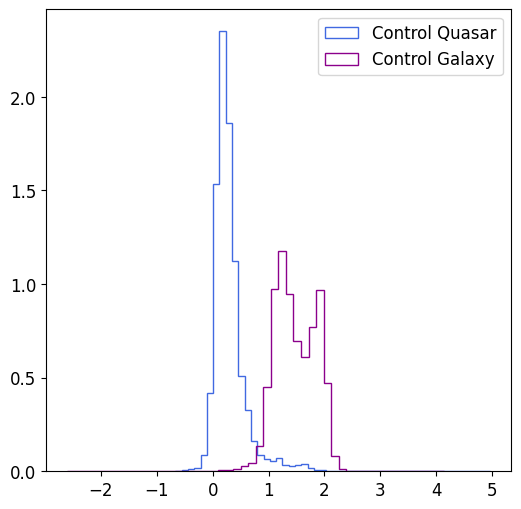

In [56]:
#Considering the u-g band
plt.hist(u_g[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
plt.hist(u_g[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
plt.legend()
plt.show()

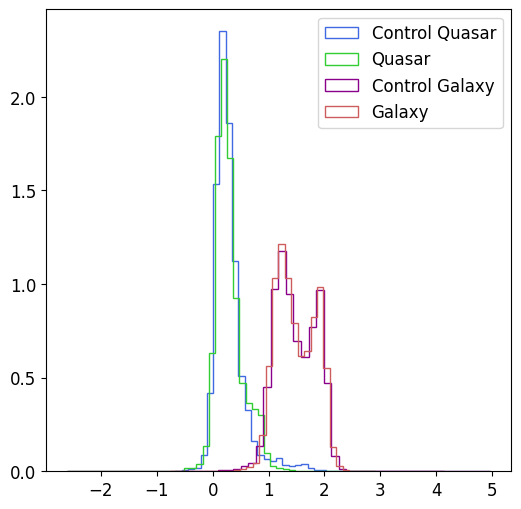

In [57]:
#Plotting
plt.hist(u_g[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
plt.hist(xtest[:, 0][result == 1], bins=50, density=True, label='Quasar', color='limegreen', histtype='step')
plt.hist(u_g[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
plt.hist(xtest[:, 0][result == 0], bins=50, density=True, label='Galaxy', color='indianred', histtype='step')
plt.legend()
plt.show()

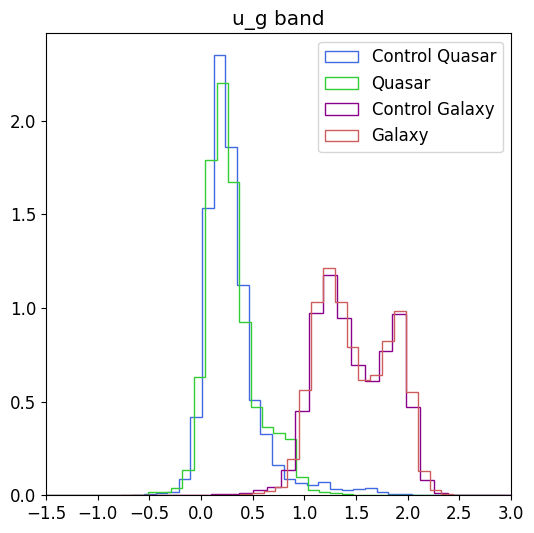

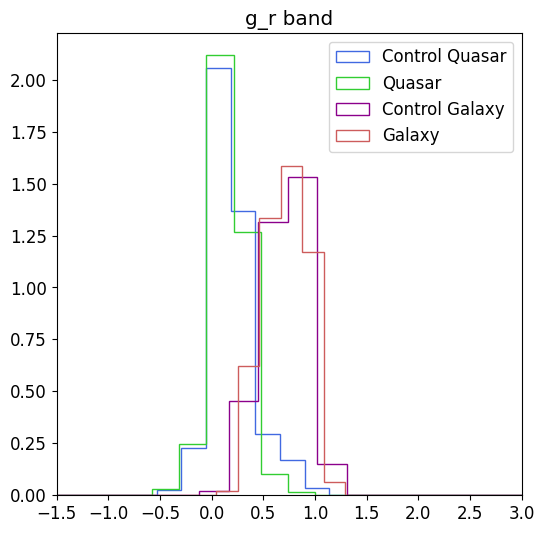

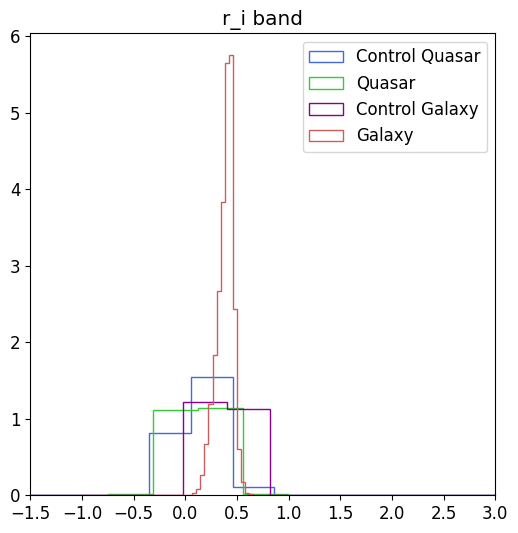

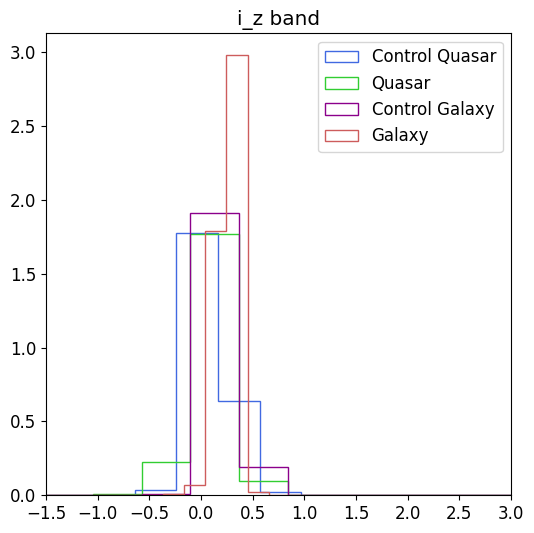

In [58]:
#Plotting
for lab, band, title in zip(range(0, 4), [u_g, g_r, r_i, i_z], ['u_g band', 'g_r band', 'r_i band', 'i_z band']):
    plt.title(title)
    plt.hist(band[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
    plt.hist(xtest[:, lab][result == 1], bins=50, density=True, label='Quasar', color='limegreen', histtype='step')
    plt.hist(band[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
    plt.hist(xtest[:, lab][result == 0], bins=50, density=True, label='Galaxy', color='indianred', histtype='step')

    plt.xlim(-1.5, 3)
    plt.legend()
    plt.show()

Metrics Accuracy Score:  0.9695466666666667
Confusion matrix:
[[31414   727]
 [  415  4944]]


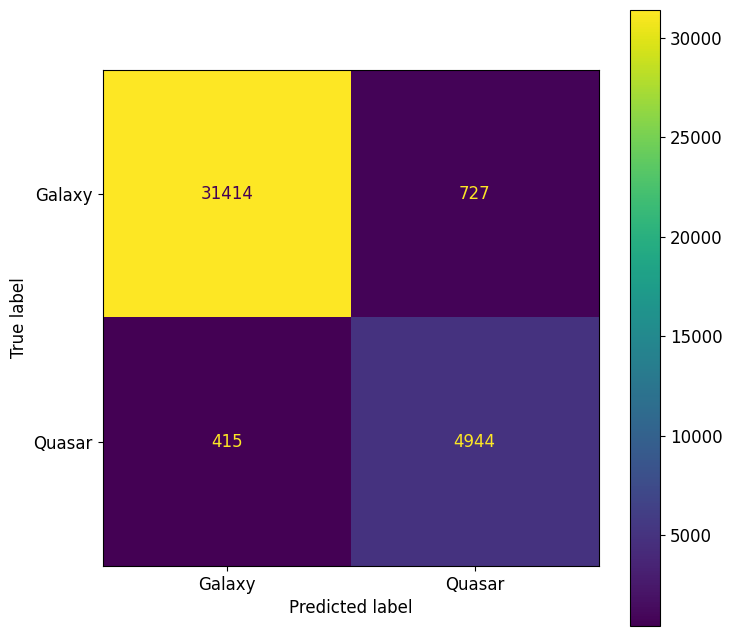

In [64]:
print('Metrics Accuracy Score: ', sklearn.metrics.accuracy_score(ytest, result))

fig, ax = plt.subplots(figsize=(8, 8))

conf_matrix = sklearn.metrics.confusion_matrix(ytest, result)

print(f"Confusion matrix:\n{conf_matrix}")

display = sklearn.metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=['Galaxy', 'Quasar']).plot(ax=ax)
plt.show()

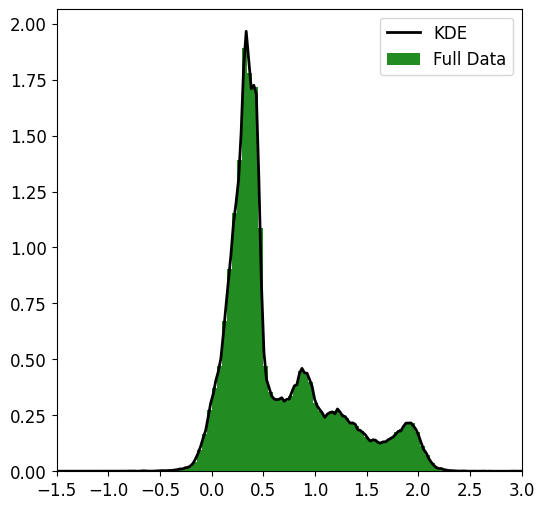

In [96]:
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde.fit(data[:, np.newaxis])
    log_pdf = kde.score_samples(xgrid[:, np.newaxis])
    
    #Result of fit is a log pdf
    pdf = np.exp(log_pdf)
    return pdf



full_data_quasar = tofit[].ravel()
full_data_galaxy = tofit.ravel()



bandwidth = 0.01

KDE = kde_sklearn(full_data, bandwidth, kernel='gaussian')

xgrid = np.linspace(full_data.min(), full_data.max(), 1000)
plt.plot(xgrid, KDE, label='KDE', c='k', ls='-', lw=2)
plt.hist(full_data, bins = 500, density=True, label='Full Data', color='forestgreen')

plt.xlim(-1.5, 3)
plt.legend()
plt.show()